In [19]:
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import optuna

c:\Users\vinor\Desktop\Develhope\projects\EDU-TreeBasedModels\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
df = pd.read_csv('data/breast-cancer.csv')
df = df.drop(columns=['id'])

# Label encoding for the diagnosis column
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])
y = df['diagnosis']
X = df.drop(columns=['diagnosis'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


# Simple training

In [12]:
# Select the model
rf_classifier = rfc(n_estimators=600, min_samples_leaf=0.12, random_state=42)

# Fit rf to the training set    
rf_classifier.fit(X_train, y_train) 

# Predict the test set labels
y_pred = rf_classifier.predict(X_test)

# Evaluate the test set RMSE
accuracy = accuracy_score(y_test, y_pred)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(accuracy))

Test set RMSE of rf: 0.95


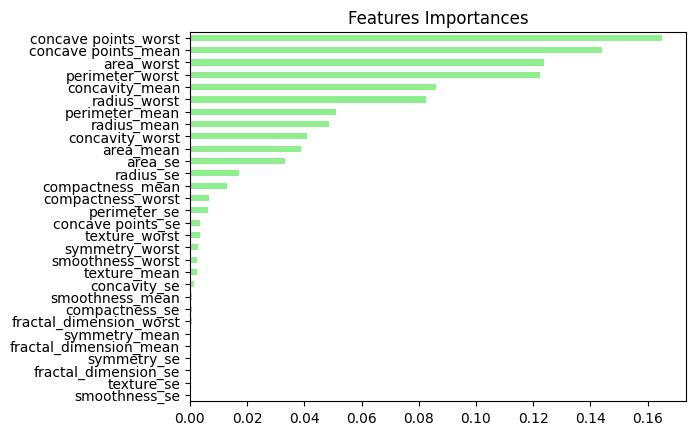

In [13]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf_classifier.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

# Grid Search

In [14]:
# The hyperparameters
rf_classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.12,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 600,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [15]:
# Define the dictionary 'params_rf'
params_rf = {
            'n_estimators' : [100,350,500],
            'max_features' : ['log2','auto','sqrt'],
            'min_samples_leaf' : [2,10,30]            
}

In [16]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

rf_classifier = rfc()

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf_classifier,
                       param_grid=params_rf,
                       scoring='accuracy',
                       cv=3,
                       # verbose=1,
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)


c:\Users\vinor\Desktop\Develhope\projects\EDU-TreeBasedModels\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
27 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vinor\Desktop\Develhope\projects\EDU-TreeBasedModels\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vinor\Desktop\Develhope\projects\EDU-TreeBasedModels\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\vinor\Desktop\Develhope\projects\EDU-Tre

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'auto', 'sqrt'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [100, 350, 500]},
             scoring='accuracy')

In [17]:
# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print rmse_test
print('Test Accuracy of best model: {:.3f}'.format(accuracy)) 

Test Accuracy of best model: 0.969


# Bayesian Optimization

In [25]:
def objective(trial):
    # Definizione degli iperparametri da ottimizzare
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # Configurazione del modello con gli iperparametri suggeriti
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Calcolo del punteggio medio tramite validazione incrociata
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1).mean()
    return score


In [ ]:
# Creazione dello studio per l'ottimizzazione
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Risultati
print("Migliori parametri trovati:", study.best_params)
print("Miglior score:", study.best_value)

[I 2024-12-13 19:05:07,116] A new study created in memory with name: no-name-d2f43b99-4cab-4114-9be5-b8550921cfd1
[I 2024-12-13 19:05:12,158] Trial 0 finished with value: 0.9384153599337578 and parameters: {'n_estimators': 448, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 0.9535248660709378}. Best is trial 0 with value: 0.9384153599337578.
[I 2024-12-13 19:05:15,143] Trial 1 finished with value: 0.9325415308181958 and parameters: {'n_estimators': 328, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 0.12157580797980153}. Best is trial 0 with value: 0.9384153599337578.
[I 2024-12-13 19:05:20,040] Trial 2 finished with value: 0.9354913833255706 and parameters: {'n_estimators': 405, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 0.986172284499517}. Best is trial 0 with value: 0.9384153599337578.
[I 2024-12-13 19:05:22,090] Trial 3 finished with value: 0.9325674067173835 and parameters: {'

In [24]:
# Valutazione sul test set con il miglior modello trovato
best_model = RandomForestClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    max_features=study.best_params['max_features'],
    random_state=42
)

best_model.fit(X_train, y_train)
print("Accuracy sul test set:", best_model.score(X_test, y_test))


Accuracy sul test set: 0.956140350877193
